# Tutorial03: Classifier Performance Measures
> Created Aug. 2024 for the FSU Course: *Machine Learning in Physics* <br>
> H. B. Prosper<br>


## Introduction

In the notebook `tutorial01`, we built a simple **discriminant** $D(x)$ to classify the points $x \in \mathbb{R}^2$ sampled from two known Gaussians. In motebook `tutorial02`, we evaluated the discriminant using the **Receiver Operating Characteristic** (ROC) curve and the **Area Under the (ROC) Curve** (AUC). In this notebook, we introduce a few other useful measures to characterize the performance of a classifier.

In [26]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn off if the system can'r find late
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Constants

In [27]:
BASE = '../../Lab01' # base location of model

MODELFILE = f'{BASE:s}/code/nnmodel.dict' # file containing parameters of trained model

INPUTS = ['x1', 'x2']

TARGET = 'target'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Exact density

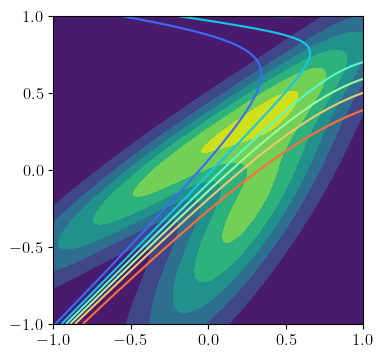

(101, 101)

In [28]:
# update paths searched by Python to find packages/modules

sys.path.append(f'{BASE:s}/code')

from exactdensity import ExactDensity

fexact = ExactDensity()
x1, x2 = fexact.grid()

fig = plt.figure(figsize=(4, 4))
ax  = fig.add_subplot(111)

tickmarks = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax.set_xticks(tickmarks)
ax.set_yticks(tickmarks)

ax.contourf(x1, x2, fexact(x1, x2))

pexact = fexact.prob(x1, x2)
ax.contour(x1, x2, pexact, cmap='rainbow')
plt.show()

pexact.shape

## Load trained (i.e., fitted) model

In [29]:
from nnmodel import model

model.load_state_dict(torch.load(MODELFILE))

model

Sequential(
  (0): Linear(in_features=2, out_features=15, bias=True)
  (1): SiLU()
  (2): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=15, out_features=15, bias=True)
  (4): SiLU()
  (5): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=15, out_features=15, bias=True)
  (7): SiLU()
  (8): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (9): Linear(in_features=15, out_features=1, bias=True)
  (10): Sigmoid()
)

## Load test data

In [30]:
test_data = pd.read_csv('../data/testdata.csv')

print(len(test_data))

test_data[:5]

15000


,x1,x2,target
0,-0.458884,-1.324906,1.0
1,0.480855,0.465076,0.0
2,0.907871,0.937647,1.0
3,0.469942,0.002835,1.0
4,0.452462,0.345677,1.0


## Compute approximate discriminant values

In [31]:
X = test_data[INPUTS].to_numpy()
Y = test_data[TARGET].to_numpy()

X.shape, Y.shape

((15000, 2), (15000,))

In [32]:
x = torch.tensor(X).float() # need to use float32 numbers not float64

Dapprox = model(x).detach().numpy().flatten()

Dapprox.shape

(15000,)

## Compute exact discriminant values

In [33]:
fexact = ExactDensity()

X1 = X[:, 0] # extract all rows (:) of column 0
X2 = X[:, 1] # extract all rows (:) of column 1

Dexact = fexact.prob(X1, X2)

Dexact.shape

(15000,)

## Divide data into "positives" and "negatives"
Objects of the "positive" class are defined by $y > 1/2$, while objects of the "negative" class as defined by $y < 1/2$.

In [34]:
positives = Dapprox[Y > 0.5]

negatives = Dapprox[Y < 0.5]

len(Dapprox), len(positives), len(negatives)

(15000, 7514, 7486)

### True Positives (TP), 

\begin{align}
    \text{TP} & : \sum_{i \, |\, y_i = 1} \mathbb{I}[D(x_i) > t], \\
    \text{FN} & : \sum_{i \, | \, y_i = 1} \mathbb{I}[D(x_i) \leq t], \\
    \text{FP} & : \sum_{i \, | \, y_i = 0} \mathbb{I}[D(x_i) > 1], \\
    \text{TN} & : \sum_{i \, | \, y_i = 0} \mathbb{I}[D(x_i) \leq 1] .
\end{align}

We'll choose the threshold at $t = 0.5$.

In [35]:
t = 0.5

TP = np.sum(positives >  t)
FN = np.sum(positives <= t)
FP = np.sum(negatives >  t)
TN = np.sum(negatives <= t)

TP, FN, FP, TN, TP+FN+FP+TN

(6322, 1192, 626, 6860, 15000)

## Plot distributions of discriminant values
What we are doing here is approximating the densities

\begin{align}
    p(D | 0) & = \int_{\mathbb{R}^2} \delta(D - f(x)) \, p(x | 0) \, dx, \\
    p(D | 1) & = \int_{\mathbb{R}^2} \delta(D - f(x)) \, p(x | 1) \, dx,
\end{align}

using histograms.

D_dist_1_t0.9.png


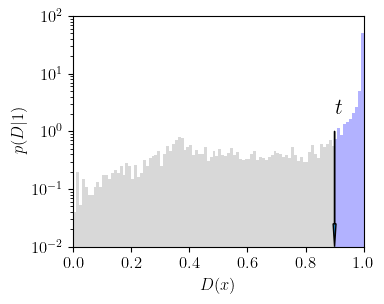

D_dist_0_t0.9.png


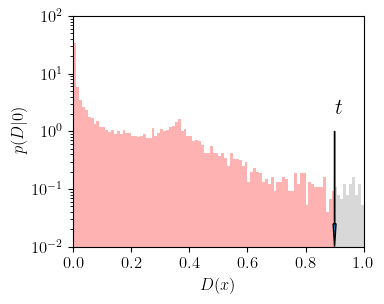

In [138]:
def plot_distribution(D, y, which=1, t=0.5,
                      nbins=100, ymin=1.e-2, ymax=1e2,
                      ftsize=FONTSIZE, 
                      fgsize=(4, 3.2)):

    # select objects (points)
    if which == 1:
        d = D[y > 0.5] 
        kolor = 'blue'
        leftlabel =  f'FN / $y = {which:d}$'
        rightlabel = f'TP / $y = {which:d}$'

        kstart = 0
        kend = int(nbins * t + 0.5)
    else: 
        d = D[y < 0.5]
        kolor = 'red'
        leftlabel =  f'TN / $y = {which:d}$'
        rightlabel = f'FP / $y = {which:d}$'
        kstart = int(nbins * t + 0.5)
        kend = nbins
        
    gfile = f'D_dist_{which:d}_t{t:3.1f}.png'
    
    # set size of figure
    fig = plt.figure(figsize=fgsize)
    
    plt.xlim(0, 1)
    plt.xlabel('$D(x)$')
    
    plt.ylim(ymin, ymax)
    plt.ylabel(f'$p(D|{which:d})$')
    plt.yscale('log') 
    
    _,_, patches = plt.hist(d, 
             bins=nbins, 
             color=kolor,
             alpha=0.3,
             range=(0, 1), 
             density=True)
    

    for i in range(kstart, kend):
        patches[i].set_facecolor('grey')

    #plt.text(0.10, 0.02, leftlabel, fontsize=16)
    #plt.text(0.60, 0.02, rightlabel, fontsize=16)
    plt.text(t, 2.0, '$t$', fontsize=16)
    plt.arrow(t, 1.0, 0, -1.0+ymin, head_width=0.01, length_includes_head=True)
    fig.tight_layout()
    
    print(gfile)
    plt.savefig(gfile)
    plt.show()
    
plot_distribution(Dapprox, Y, which=1, t=0.9)
plot_distribution(Dapprox, Y, which=0, t=0.9)

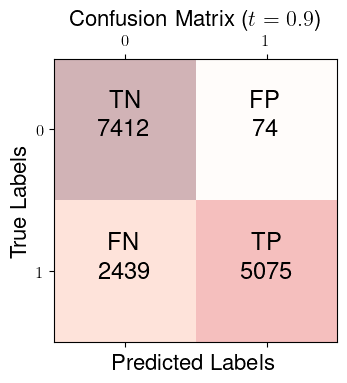

In [134]:
def plot_confusion_matrix(D, y, t=0.5, gfile='confusion_matrix.png'):
    from sklearn.metrics import confusion_matrix

    y_pred = D > t
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred)

    # Print the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.3)

    label = [['TN', 'FP'], ['FN', 'TP']]
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], 
                    va='center', ha='center', size='x-large')
            ax.text(x=j, y=i-0.2, s=label[i][j], 
                    va='center', ha='center', size='x-large')
 
    plt.xlabel('Predicted Labels', fontsize=16)
    plt.ylabel('True Labels', fontsize=16)
    plt.title(f'Confusion Matrix ($t = {t:3.1f}$)', fontsize=16)
    fig.tight_layout()
    plt.savefig(gfile)
    plt.show()
    
plot_confusion_matrix(Dapprox, Y, t=0.9, gfile='confusion_matrix_t0.9.png')

## Now compute ROC and AUC

First compute

\begin{align}
    \mathbb{P}(D > t|k) & = \int_{D=t}^{D=1} p(D | k) \, dD,\quad k = 0, 1,
\end{align}

The ROC curve is $\mathbb{P}(D > t|1) \text{ vs. } \mathbb{P}(D > t|0)$ and the AUC is simply the area beneath it.

In [129]:
# standard measures of model performance
from sklearn.metrics import roc_curve, auc

def plot_ROC(y, D):
    
    bkg, sig, _ = roc_curve(y, D)
    
    roc_auc = auc(bkg, sig)
    
    fig = plt.figure(figsize=(4.0, 3.8))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('$P(D > t|0)$', fontsize=16)
    plt.ylabel('$P(D > t|1)$', fontsize=16)
    
    plt.plot(bkg, sig, color='red',
             lw=1, label='ROC curve, AUC = %0.2f)' % roc_auc)
    
    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.legend(loc="lower right", fontsize=11)
    fig.tight_layout()
    plt.savefig("ROC.png")
    plt.show()

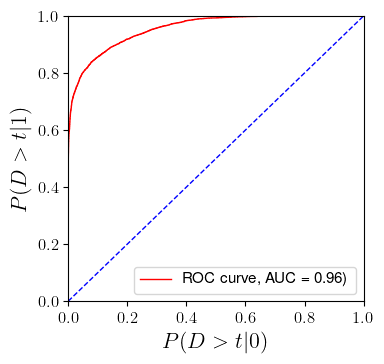

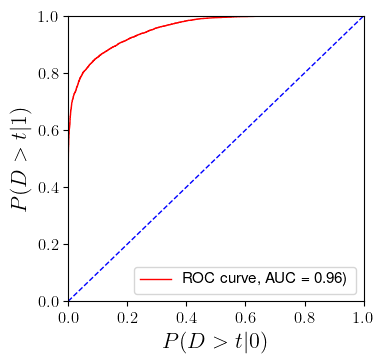

In [130]:
plot_ROC(Y, Dexact)
plot_ROC(Y, Dapprox)